In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# from einops import rearrange, repeat
# import rosbags
import json
import open3d as o3d
import pandas as pd
import os
import copy
from utility import listFiles, quickVizNumpy
from scipy.spatial.transform import Rotation as R
from numpy import cos, sin, sqrt, arctan2, array
import torch.nn as nn
### fucking around
# from pretrain import loadDataFromRegisteredSlam, cart2sph, preProcess
# from train import getSamples, getUpSamples, getSpacing


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
name = r'building'
path = r'datasets/registered/' + name + r'.json'
data = loadDataFromRegisteredSlam(path)
training_data = preProcess(data)
np.random.shuffle(training_data)

Preparing data ... (950/971)

In [6]:
sigmoid_ = nn.Sigmoid()
t = torch.tensor(np.linspace(-10, 10, 1000))
y = sigmoid_(t)
local_trans = 1 - y * (1 - y)
s = torch.cumprod(local_trans, 0)



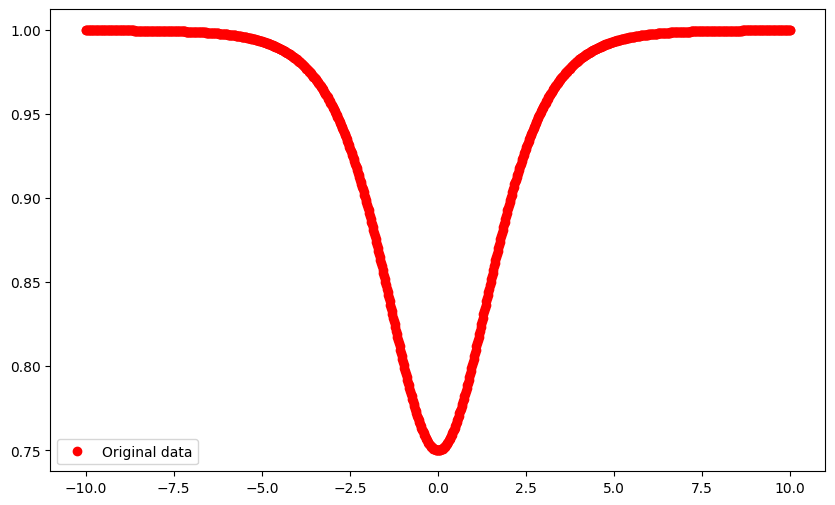

In [14]:
x_data = np.linspace(-10,10,1000)
y_data = local_trans.detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'ro', label='Original data')
plt.legend()
plt.show()

In [4]:
y

tensor([4.5398e-05, 4.6316e-05, 4.7252e-05, 4.8208e-05, 4.9183e-05, 5.0177e-05,
        5.1192e-05, 5.2227e-05, 5.3283e-05, 5.4360e-05, 5.5460e-05, 5.6581e-05,
        5.7725e-05, 5.8892e-05, 6.0083e-05, 6.1298e-05, 6.2538e-05, 6.3802e-05,
        6.5092e-05, 6.6408e-05, 6.7751e-05, 6.9121e-05, 7.0519e-05, 7.1945e-05,
        7.3400e-05, 7.4884e-05, 7.6398e-05, 7.7943e-05, 7.9519e-05, 8.1127e-05,
        8.2767e-05, 8.4440e-05, 8.6148e-05, 8.7890e-05, 8.9667e-05, 9.1480e-05,
        9.3330e-05, 9.5217e-05, 9.7142e-05, 9.9106e-05, 1.0111e-04, 1.0315e-04,
        1.0524e-04, 1.0737e-04, 1.0954e-04, 1.1175e-04, 1.1401e-04, 1.1632e-04,
        1.1867e-04, 1.2107e-04, 1.2352e-04, 1.2602e-04, 1.2856e-04, 1.3116e-04,
        1.3381e-04, 1.3652e-04, 1.3928e-04, 1.4210e-04, 1.4497e-04, 1.4790e-04,
        1.5089e-04, 1.5394e-04, 1.5705e-04, 1.6023e-04, 1.6347e-04, 1.6677e-04,
        1.7015e-04, 1.7359e-04, 1.7710e-04, 1.8068e-04, 1.8433e-04, 1.8806e-04,
        1.9186e-04, 1.9574e-04, 1.9970e-